In [1]:
from torchvision import datasets, models, transforms
import torch
import torch.nn as nn
import torch.optim as optim
from copy import deepcopy,copy
from myDataset import PalmNutriDataset
import matplotlib.pyplot as plt
import numpy as np
import pickle
sample_set = 'n33'
target = 'n'

plt.style.use('seaborn-whitegrid')

to_do = [('alex',       f'alexnet_{sample_set}/alex_{sample_set}'),
         ('mobilenet',  f'mobilenet_{sample_set}/mobilenet_{sample_set}'),
         ('resnext',    f'resnext_{sample_set}/resnext_{sample_set}')
         ]

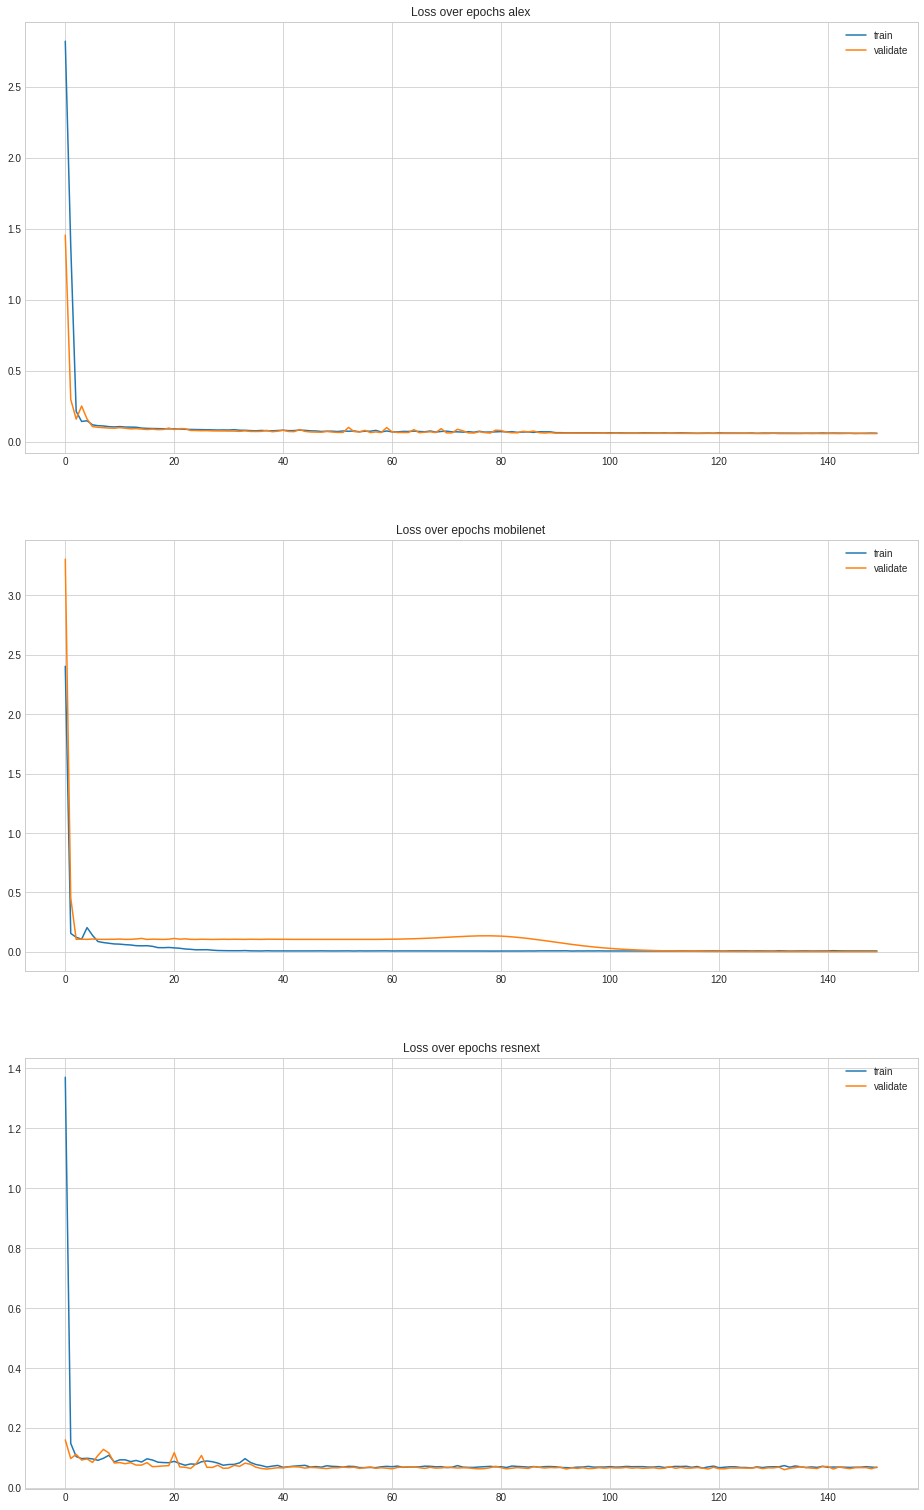

In [2]:
# Plot training result
fig,ax = plt.subplots(nrows=3, figsize=(16,9*3))
for index, (name, path) in enumerate(to_do):
    train_loss = pickle.load(open(f'{path}_train_loss.txt', 'rb'))
    val_loss = pickle.load(open(f'{path}_val_loss.txt', 'rb'))
    ax[index].set_title(f'Loss over epochs {name}')
    ax[index].plot(train_loss, label='train')
    ax[index].plot(val_loss, label='validate')
    ax[index].legend()
plt.show()

del(val_loss)
del(train_loss)

In [3]:
# the magic number
mean, std = (0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)

preprocess_augment = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

preprocess = transforms.Compose([
    transforms.Resize([256,256]),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean, std)])

ground_truth = 'dataset/gt.csv'
full_dataset = PalmNutriDataset(ground_truth=ground_truth, img_dir='dataset', sample_set=sample_set,target=target)
full_dataset.transform = preprocess
print(len(full_dataset))

BATCH_SIZE=64
NUM_WORKERS=2
dataloader = torch.utils.data.DataLoader(full_dataset, batch_size=BATCH_SIZE,shuffle=True , num_workers=NUM_WORKERS)

1018


In [6]:
def load_model(name, pretrain=None):
    model = None
    if(name == 'alex'):
        model = models.alexnet()
        model.classifier[6] = torch.nn.Linear(in_features=4096,out_features=1,bias=True)
    elif(name == 'mobilenet'):
        model = models.mobilenet_v3_large()
        model.classifier[3] = torch.nn.Linear(in_features=1280,out_features=1,bias=True)
    elif(name == 'resnext'):
        model = models.resnext50_32x4d()
        model.fc = torch.nn.Linear(in_features=2048,out_features=1,bias=True)
    else:
        raise ValueError(f"name:{name} is not defined")

    if(pretrain!=None):
        model.load_state_dict(torch.load(pretrain, map_location='cpu'))
    return model

import math
def get_class(score, target):
    if(target == 'n'):
        n_range = [0,2,2.4,3,math.inf]
        if(score < 2):
            return 1
        if(score < 2.4):
            return 2
        if(score < 3):
            return 3
        else: return 4
    elif(target == 'k'):
        k_range = [0,0.75,0.90,1.2,math.inf]
        if(score < .75):
            return 1
        if(score < .9):
            return 2
        if(score < 1.2):
            return 3
        else: return 4
    else:
        raise ValueError(f"target:{target} is incorrect")


def predict(model, dataloader, device='cpu'):
    all_preds = None
    all_labels = None
    model.to(device)
    with torch.no_grad():
        for index, (inputs,labels) in enumerate(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device).view(-1,1)
            # print(inputs,labels)
            preds = model(inputs)
            if(all_preds == None):
                all_preds = preds.cpu().view(-1)
                all_labels = labels.cpu().view(-1)
            else:
                all_preds = torch.cat( [all_preds,preds.cpu().view(-1)],dim=0)
                all_labels = torch.cat( [all_labels,labels.cpu().view(-1)],dim=0)

    return all_preds, all_labels

def print_performance(all_preds, all_labels, target):
    acc = 0
    acc_class = dict()
    len_class = dict()
    err = 0
    err_class = dict()
    # class_3 = []
    for idx in range(len(all_preds)):
        # get class
        pred,label = all_preds[idx], all_labels[idx]
        class_pred = get_class(pred, target)
        class_act = get_class(label, target)
        
        # init if unseen class
        if(class_act not in len_class.keys()):
            acc_class[class_act] = 0
            err_class[class_act] = 0
            len_class[class_act] = 1

        # Check result
        if(class_act == class_pred):
            acc += 1
            acc_class[class_act] += 1
        len_class[class_act] += 1
        err += abs(pred - label)
        err_class[class_act] += abs(pred - label)
        # if(class_act == 3 and class_pred != 3):
        #     class_3.append((full_dataset.filenames[idx],pred,label))

    print('Over All acc: ',acc/len(all_preds) * 100)
    print('Over All err: ',err/len(all_preds))

    for k,v in acc_class.items():
        print(f"Acc of Class {k}: {v}/{len_class[k]} = {v/len_class[k] * 100}")
        print(f"Err of Class {k}: {err_class[k]/len_class[k]}")


alex alexnet_n33/alex_n33
Over All acc:  59.13555992141454
Over All err:  tensor(0.1902)
Acc of Class 3: 227/372 = 61.02150537634409
Err of Class 3: 0.16679388284683228
Acc of Class 1: 73/242 = 30.165289256198346
Err of Class 1: 0.2844482660293579
Acc of Class 2: 302/396 = 76.26262626262627
Err of Class 2: 0.14127223193645477
Acc of Class 4: 0/12 = 0.0
Err of Class 4: 0.5677617192268372

mobilenet mobilenet_n33/mobilenet_n33
Over All acc:  84.57760314341847
Over All err:  tensor(0.0780)
Acc of Class 2: 330/396 = 83.33333333333334
Err of Class 2: 0.07418665289878845
Acc of Class 4: 8/12 = 66.66666666666666
Err of Class 4: 0.08567134290933609
Acc of Class 3: 314/372 = 84.40860215053763
Err of Class 3: 0.08150941878557205
Acc of Class 1: 209/242 = 86.36363636363636
Err of Class 1: 0.07737652957439423

resnext resnext_n33/resnext_n33
Over All acc:  51.080550098231825
Over All err:  tensor(0.2067)
Acc of Class 3: 139/372 = 37.365591397849464
Err of Class 3: 0.22399532794952393
Acc of Class 

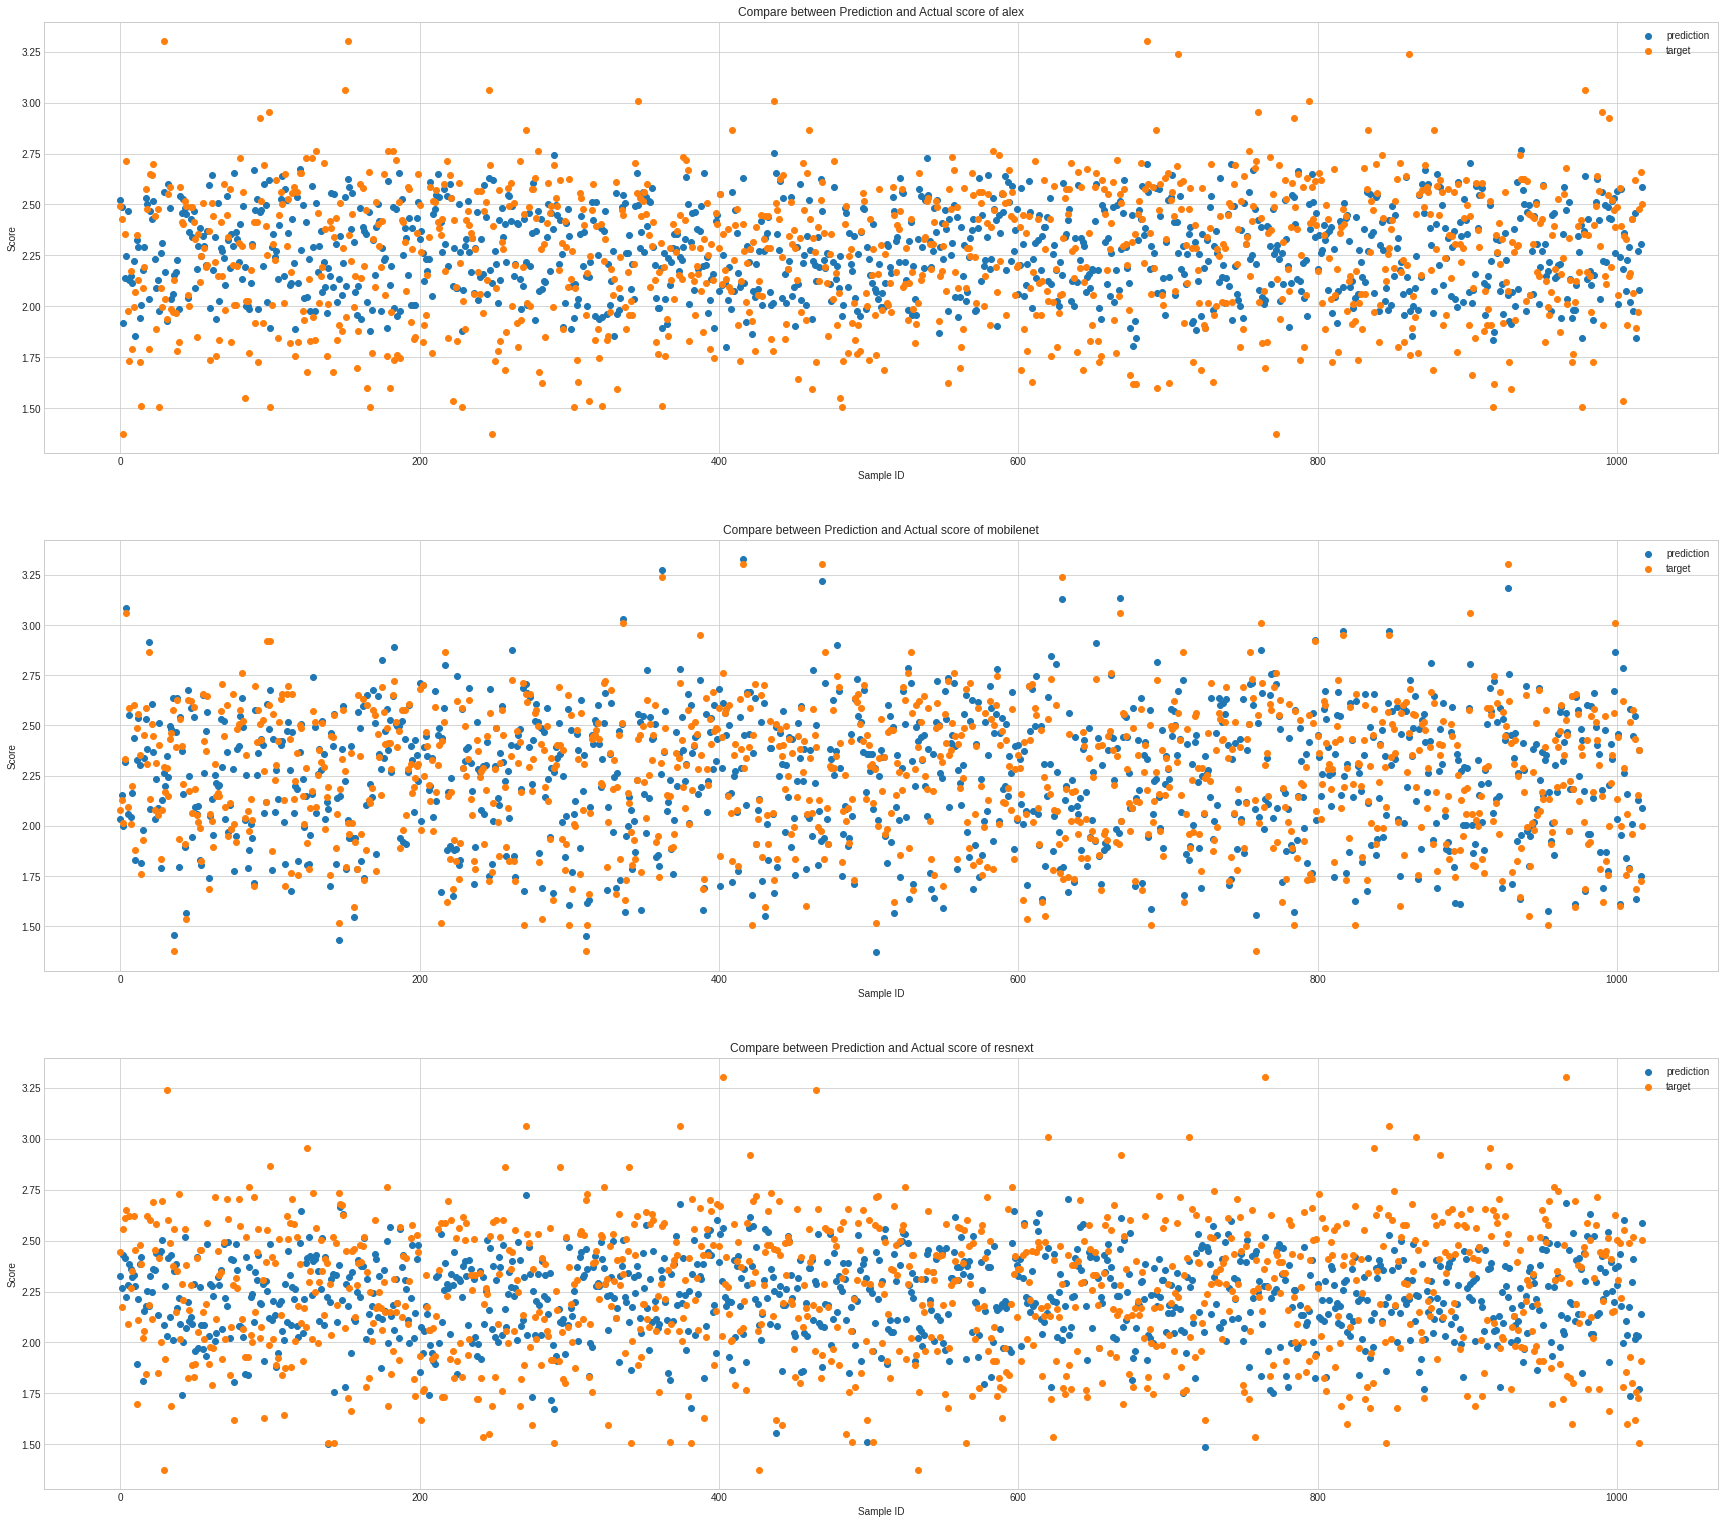

In [7]:
preds_of = dict()
labels_of = dict()
fig,ax = plt.subplots(3, figsize=(30,9*3))
for index, (name, weight) in enumerate(to_do):
    print(name, weight)
    print('='*20)
    model = load_model(name, f'{weight}.pth')
    all_preds, all_labels = predict(model, dataloader, 'cuda:0')
    preds_of[name] = all_preds
    labels_of[name] = all_labels
    ax[index].scatter(np.arange(len(all_preds)),all_preds,label='prediction')
    ax[index].scatter(np.arange(len(all_labels)),all_labels,label='target')
    ax[index].set_title(f'Compare between Prediction and Actual score of {name}')
    ax[index].set_ylabel('Score')
    ax[index].set_xlabel('Sample ID')
    ax[index].legend()
    print_performance(all_preds, all_labels, target)
    print()

plt.show()
del(model)

Top 5 Error example from [alex]
Filename:N433_33_3.JPG
Score Label:2.86299991607666|Pred:2.0747578144073486|diff=0.7882421016693115
Class Label:3|Pred:2


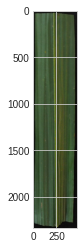

Filename:N364_33_1.JPG
Score Label:3.240000009536743|Pred:2.0738749504089355|diff=1.1661250591278076
Class Label:4|Pred:2


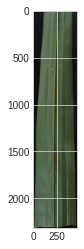

Filename:N383_33_3.JPG
Score Label:1.6859999895095825|Pred:2.579045534133911|diff=0.8930455446243286
Class Label:1|Pred:3


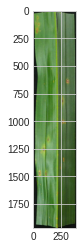

Filename:N259_33_5.JPG
Score Label:3.240000009536743|Pred:2.2596447467803955|diff=0.9803552627563477
Class Label:4|Pred:2


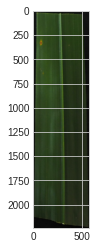

Filename:N248_33_1.JPG
Score Label:1.3760000467300415|Pred:2.278806686401367|diff=0.9028066396713257
Class Label:1|Pred:2


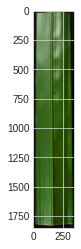

Top 5 Error example from [mobilenet]
Filename:N387_33_4.JPG
Score Label:2.4519999027252197|Pred:2.1036205291748047|diff=0.34837937355041504
Class Label:3|Pred:2


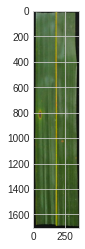

Filename:N157_33_3.JPG
Score Label:1.628999948501587|Pred:2.006641387939453|diff=0.3776414394378662
Class Label:1|Pred:2


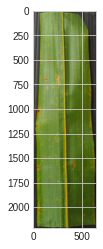

Filename:N189_33_2.JPG
Score Label:2.6540000438690186|Pred:2.2838335037231445|diff=0.370166540145874
Class Label:3|Pred:2


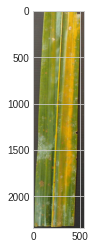

Filename:N295_33_1.JPG
Score Label:2.6670000553131104|Pred:2.281693935394287|diff=0.38530611991882324
Class Label:3|Pred:2


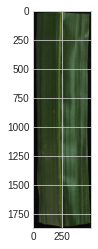

Filename:N429_33_1.JPG
Score Label:2.7049999237060547|Pred:2.2904751300811768|diff=0.41452479362487793
Class Label:3|Pred:2


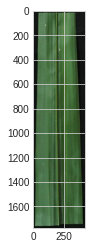

Top 5 Error example from [resnext]
Filename:N323_33_3.JPG
Score Label:3.3010001182556152|Pred:2.515760660171509|diff=0.7852394580841064
Class Label:4|Pred:3


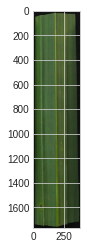

Filename:N327_33_3.JPG
Score Label:2.9519999027252197|Pred:2.144120216369629|diff=0.8078796863555908
Class Label:3|Pred:2


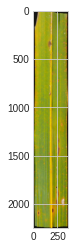

Filename:N255_33_3.JPG
Score Label:3.240000009536743|Pred:2.030097007751465|diff=1.2099030017852783
Class Label:4|Pred:2


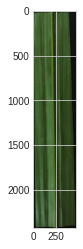

Filename:N216_33_1.JPG
Score Label:1.5369999408721924|Pred:2.4329864978790283|diff=0.8959865570068359
Class Label:1|Pred:3


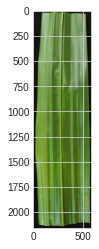

Filename:N211_33_3.JPG
Score Label:3.240000009536743|Pred:2.2880699634552|diff=0.951930046081543
Class Label:4|Pred:2


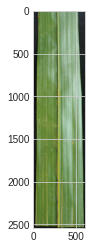

In [8]:
import matplotlib.image as mpimg

for name,_ in to_do:
    print(f"Top 5 Error example from [{name}]")
    print("="*20)
    preds = preds_of[name]
    labels = labels_of[name]
    errors = abs(preds - labels).numpy()
    # get top 5 error  
    idxs = np.argpartition(errors, -5)[-5:]
    for idx in idxs:
        filename = full_dataset.filenames[idx]
        pred = preds[idx]
        label = labels[idx]
        print(f"Filename:{filename}")
        print(f"Score Label:{label}|Pred:{pred}|diff={abs(label-pred)}")
        print(f"Class Label:{get_class(label,target)}|Pred:{get_class(pred,target)}")
        img = mpimg.imread(f'dataset/{sample_set}/{filename}')
        plt.imshow(img)
        plt.show()